<a href="https://colab.research.google.com/github/aantia/crypto_data_analysis/blob/main/crypto_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install stuff
!pip install requests
!pip install plotly
!pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 188 kB/s 
     |████████████████████████████████| 62 kB 667 kB/s 
     |████████████████████████████████| 6.4 MB 10.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but y

In [25]:
# import stuff
import requests
import time
import datetime
import json
import sqlite3
import pandas as pd
import numpy as np
import quantstats as qs
import plotly.express as px
try:
    from IPython.core.display import (
        display as iDisplay, HTML as iHTML
    )
except ImportError:
    pass
from quantstats import (
    __version__, stats as _stats,
    utils as _utils, plots as _plots
)
from tabulate import tabulate as _tabulate

In [3]:
# set global variables

# coingecko ratecap (/m)
ratecap = 45

# coingecko rate usage tracker
gecko = 0

In [22]:
# define functions

# prints a javascript object
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)
    
# convert a timestamp in a dataframe to a python date object
def df_timestamp_to_date(row):
    return datetime.date.fromtimestamp(row['timestamp']/1000)
    
# convert a timestamp in a dataframe to a python datetime object
def df_timestamp_to_datetime(row):
    return datetime.datetime.fromtimestamp(row['timestamp']/1000)

# get coingecko data from a certain date
# format: jprint(coingecko_price_request(datetime.date.fromisoformat("2022-03-22"), "fantom"))
def coingecko_price_request(date, token):
  global gecko
  gecko+=1
  if gecko == ratecap:
    print('sleeping 70s')
    time.sleep(70)
    gecko = 0
  response = requests.get("https://api.coingecko.com/api/v3/coins/"+ token +"/history?date=" + date.strftime("%d-%m-%Y"))
  try:
    return json.loads(response.content)
  except:
    # Note: 429 is too many requests
    print("Coingecko no json. Response code: " + str(response.status_code))
    print("Retrying in 80s if this was 429")
    if response.status_code == 429:
        print('number of iterations since last sleep: ' + str(gecko))
        gecko = 0
        time.sleep(80)
        return coingecko_price_request(date)

# get coingecko market cap, price, volume data from a range of dates
# format: jprint(coingecko_chart_request('tarot', datetime.date.fromisoformat("2000-01-01"), datetime.date.fromisoformat("2022-12-31")))
# this returns serieses of prices, market_caps, and total_volumes (this is for 24h). Each series has two values per date
def coingecko_chart_request(token, startdate, enddate):
  global gecko
  gecko+=1
  # this endpoint seems to have a lower ratelimit
  if gecko == 7:
    print('sleeping 70s')
    time.sleep(70)
    gecko = 0
  req = "https://api.coingecko.com/api/v3/coins/"+ token +"/market_chart/range?vs_currency=usd&from="+\
                         str(datetime.datetime.combine(startdate, datetime.time.min).timestamp()) + "&to=" + \
                         str(datetime.datetime.combine(enddate, datetime.time.min).timestamp())
  print(req)
  response = requests.get(req)
  try:
    return json.loads(response.content)
  except:
    # Note: 429 is too many requests
    print("Coingecko no json. Response code: " + str(response.status_code))
    print("Retrying in 80s if this was 429")
    if response.status_code == 429:
        print('number of iterations since last ratelimit: ' + str(gecko))
        gecko = 0
        time.sleep(80)
        return coingecko_chart_request(token, startdate, enddate)
        
# insert array of tokens into database
# note: sqlite3 allows you to do cursor.execute(query with ? variables, list of values)
def insert_tokens(tokenlist):
    
    #note: these are all the same names as Coingeck api gives, except token_id = id
    for item in tokenlist:
        query = '''
            INSERT OR REPLACE INTO tokens (token_id, symbol, name, current_price, market_cap, total_volume, circulating_supply, ath, ath_date, atl,
            atl_date, last_updated)
                VALUES
                (
        '''
        
        fieldlist = [item['id'], item['symbol'], item['name'], item['current_price'], item['market_cap'], item['total_volume'], \
                            item['circulating_supply'], item['ath'], item['ath_date'], item['atl'], item['atl_date'], item['last_updated']]
        
        query += ', '.join('?'*len(fieldlist))
        query += ');'
        
        valuelist = [str(f) for f in fieldlist]
        
        c.execute(query, tuple(valuelist))
        
    conn.commit()


# note that timeseries data from coingecko may not be daily if the timeframe starts <90 days prior to present. Need to keep an eye on this.
# requires input zipped to [([timestamp, price], [same timestamp, market cap], [same timestamp, volume]), ...]
def insert_timeseries(token, timeseries):
    for date in timeseries:
        query = '''
            INSERT OR IGNORE INTO timeseries (timestamp, token_id, price, market_cap, volume)
                VALUES (?, ?, ?, ?, ?);
        '''
        c.execute(query, tuple([date[0][0], token, date[0][1], date[1][1], date[2][1]]))
    conn.commit()
    

# calculate standard deviation
# data should be just the prices
def std_dev(data):
    # Get number of observations
    n = len(data)
    # Calculate mean
    mean = sum(data) / n
    # Calculate deviations from the mean
    deviations = sum([(x - mean)**2 for x in data])
    # Calculate Variance & Standard Deviation
    variance = deviations / (n - 1)
    s = variance**(1/2)
    return s


# calculate sharpe ratio
# data should just be just the prices for the lookback period, e.g. 1 month
def sharpe_ratio(data, risk_free_rate=0.0):
    # Calculate total return
    t_return = sum(data)
    # Calculate Standard Deviation
    s = std_dev(data)
    if s == 0: return None
    # Calculate Sharpe Ratio
    sharpe_ratio = (t_return - risk_free_rate) / s
    
    return sharpe_ratio


# THIS IS GIVING BAD VALUES, FIX BEFORE USING!
# calculate sharpe ratios
# data should be a dataframe from the timestamp table
def sharpe_ratio_column(data, risk_free_rate=0.0):    
    for i in range(len(data['timestamp'])):
        if i < 29:
            continue
        # 30-day range
        series = data['price'][i-29:i]
        sr = sharpe_ratio(series)
        data['sharpe'][i] = sr
    
    return data

# a version of qs.reports.full() with 30-day periods instead of 6m
def myreport(returns, benchmark=None, rf=0., grayscale=False,
         figsize=(14, 10), display=True, compounded=True, rolling_period=30, 
         periods_per_year=365, match_dates=True):

    # prepare timeseries
    returns = _utils._prepare_returns(returns)
    if benchmark is not None:
        benchmark = _utils._prepare_benchmark(benchmark, returns.index, rf)
        if match_dates is True:
            returns, benchmark = _match_dates(returns, benchmark)

    dd = _stats.to_drawdown_series(returns)
    col = _stats.drawdown_details(dd).columns[4]
    dd_info = _stats.drawdown_details(dd).sort_values(by = col,
                                                       ascending = True)[:5]

    if not dd_info.empty:
        dd_info.index = range(1, min(6, len(dd_info)+1))
        dd_info.columns = map(lambda x: str(x).title(), dd_info.columns)

    if _utils._in_notebook():
        iDisplay(iHTML('<h4>Performance Metrics</h4>'))
        iDisplay(qs.reports.metrics(returns=returns, benchmark=benchmark,
                         rf=rf, display=display, mode='full',
                         compounded=compounded,
                         periods_per_year=periods_per_year,
                         prepare_returns=False))
        iDisplay(iHTML('<h4>5 Worst Drawdowns</h4>'))
        if dd_info.empty:
            iDisplay(iHTML("<p>(no drawdowns)</p>"))
        else:
            iDisplay(dd_info)

        iDisplay(iHTML('<h4>Strategy Visualization</h4>'))
    else:
        print('[Performance Metrics]\n')
        qs.reports.metrics(returns=returns, benchmark=benchmark,
                rf=rf, display=display, mode='full',
                compounded=compounded,
                periods_per_year=periods_per_year,
                prepare_returns=False)
        print('\n\n')
        print('[5 Worst Drawdowns]\n')
        if dd_info.empty:
            print("(no drawdowns)")
        else:
            print(_tabulate(dd_info, headers="keys",
                            tablefmt='simple', floatfmt=".2f"))
        print('\n\n')
        print('[Strategy Visualization]\nvia Matplotlib')

    plots(returns=returns, benchmark=benchmark, rolling_period=rolling_period, 
          grayscale=grayscale, figsize=figsize, mode='full',
          periods_per_year=periods_per_year, prepare_returns=False)

    # a version of the plots function to go with the above
def plots(returns, benchmark=None, grayscale=False,
          figsize=(8, 5), mode='basic', compounded=True, rolling_period=0, 
          periods_per_year=365, prepare_returns=True, match_dates=False):

    win_year, win_half_year = qs.reports._get_trading_periods(periods_per_year)
    if rolling_period == 0:
        rolling_period = win_half_year
    
    if prepare_returns:
        returns = _utils._prepare_returns(returns)

    if mode.lower() != 'full':
        _plots.snapshot(returns, grayscale=grayscale,
                        figsize=(figsize[0], figsize[0]),
                        show=True, mode=("comp" if compounded else "sum"))

        _plots.monthly_heatmap(returns, grayscale=grayscale,
                               figsize=(figsize[0], figsize[0]*.5),
                               show=True, ylabel=False,
                               compounded=compounded)

        return

    # prepare timeseries
    if benchmark is not None:
        benchmark = _utils._prepare_benchmark(benchmark, returns.index)
        if match_dates is True:
            returns, benchmark = _match_dates(returns, benchmark)

    _plots.returns(returns, benchmark, grayscale=grayscale,
                   figsize=(figsize[0], figsize[0]*.6),
                   show=True, ylabel=False,
                   prepare_returns=False)

    _plots.log_returns(returns, benchmark, grayscale=grayscale,
                       figsize=(figsize[0], figsize[0]*.5),
                       show=True, ylabel=False,
                       prepare_returns=False)

    if benchmark is not None:
        _plots.returns(returns, benchmark, match_volatility=True,
                       grayscale=grayscale,
                       figsize=(figsize[0], figsize[0]*.5),
                       show=True, ylabel=False,
                       prepare_returns=False)

    _plots.yearly_returns(returns, benchmark,
                          grayscale=grayscale,
                          figsize=(figsize[0], figsize[0]*.5),
                          show=True, ylabel=False,
                          prepare_returns=False)

    _plots.histogram(returns, grayscale=grayscale,
                     figsize=(figsize[0], figsize[0]*.5),
                     show=True, ylabel=False,
                     prepare_returns=False)

    _plots.daily_returns(returns, grayscale=grayscale,
                         figsize=(figsize[0], figsize[0]*.3),
                         show=True, ylabel=False,
                         prepare_returns=False)

    if benchmark is not None:
        _plots.rolling_beta(returns, benchmark, grayscale=grayscale,
                            window1=win_half_year, window2=win_year,
                            figsize=(figsize[0], figsize[0]*.3),
                            show=True, ylabel=False,
                            prepare_returns=False)

    _plots.rolling_volatility(
        returns, benchmark, grayscale=grayscale, period_label=str(rolling_period)+" Days",
        figsize=(figsize[0], figsize[0]*.3), show=True, ylabel=False,
        period=win_half_year)

    _plots.rolling_sharpe(returns, grayscale=grayscale, period_label=str(rolling_period)+" Days", 
                          figsize=(figsize[0], figsize[0]*.3),
                          show=True, ylabel=False, period=rolling_period)

    _plots.rolling_sortino(returns, grayscale=grayscale, period_label=str(rolling_period)+" Days",
                           figsize=(figsize[0], figsize[0]*.3),
                           show=True, ylabel=False, period=rolling_period)

    _plots.drawdowns_periods(returns, grayscale=grayscale,
                             figsize=(figsize[0], figsize[0]*.5),
                             show=True, ylabel=False,
                             prepare_returns=False)

    _plots.drawdown(returns, grayscale=grayscale,
                    figsize=(figsize[0], figsize[0]*.4),
                    show=True, ylabel=False)

    _plots.monthly_heatmap(returns, grayscale=grayscale,
                           figsize=(figsize[0], figsize[0]*.5),
                           show=True, ylabel=False)

    _plots.distribution(returns, grayscale=grayscale,
                        figsize=(figsize[0], figsize[0]*.5),
                        show=True, ylabel=False,
                        prepare_returns=False)

In [5]:
# initialise database
conn = sqlite3.connect('coinhistory')
c = conn.cursor()

# Note: token_id should match coingecko's id field
c.execute('''
    CREATE TABLE IF NOT EXISTS tokens
    ([token_id] TEXT PRIMARY KEY, [symbol] TEXT, [name] TEXT, [current_price] REAL, [market_cap] INTEGER, 
    [total_volume] INTEGER, [circulating_supply] REAL, [ath] REAL, [ath_date] TEXT, [atl] REAL, [atl_date] TEXT, [last_updated] TEXT)
''')

# create timeseries table
c.execute('''
    CREATE TABLE IF NOT EXISTS timeseries
    (timestamp INT NOT NULL, token_id TEXT NOT NULL, price REAL, market_cap REAL, volume REAL,
    PRIMARY KEY (timestamp, token_id)
    FOREIGN KEY (token_id) REFERENCES tokens (token_id) ON DELETE CASCADE ON UPDATE CASCADE);
''')

conn.commit()

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
# merge together the starter data (for tokens)
mergedtokens = list()
for i in range(5):
    with open(r"/content/drive/MyDrive/token_db/tokens_" + str(i+1) + ".json") as tokenfile:
        mergedtokens += (json.load(tokenfile))
        
jprint(mergedtokens)

[
    {
        "ath": 1.32,
        "ath_change_percentage": -24.41792,
        "ath_date": "2018-07-24T00:00:00.000Z",
        "atl": 0.572521,
        "atl_change_percentage": 74.6701,
        "atl_date": "2015-03-02T00:00:00.000Z",
        "circulating_supply": 72430549552.519,
        "current_price": 1,
        "fully_diluted_valuation": null,
        "high_24h": 1.003,
        "id": "tether",
        "image": "https://assets.coingecko.com/coins/images/325/large/Tether-logo.png?1598003707",
        "last_updated": "2022-06-09T16:32:13.921Z",
        "low_24h": 0.996955,
        "market_cap": 72466926182,
        "market_cap_change_24h": 70775796,
        "market_cap_change_percentage_24h": 0.09776,
        "market_cap_rank": 3,
        "max_supply": null,
        "name": "Tether",
        "price_change_24h": 0.00041425,
        "price_change_percentage_24h": 0.04142,
        "roi": null,
        "symbol": "usdt",
        "total_supply": 72430549552.519,
        "total_volume": 29

In [9]:
# insert tokens
insert_tokens(mergedtokens)

In [10]:
# display tokens
c.execute("SELECT * from tokens LIMIT 20")
df = pd.DataFrame(c.fetchall(), columns = ['id', 'symbol', 'name', 'current_price', 'market_cap', 'total_volume', 'circulating_supply', \
                                           'ath', 'ath_date', 'atl', 'atl_date', 'last_updated'])

print(df)

                    id symbol                name  current_price  \
0               tether   usdt              Tether       1.000000   
1              bitcoin    btc             Bitcoin   30226.000000   
2             ethereum    eth            Ethereum    1794.480000   
3          binance-usd   busd         Binance USD       1.000000   
4             usd-coin   usdc            USD Coin       1.001000   
5            flex-coin   flex           FLEX Coin       4.940000   
6                 vndc   vndc                VNDC       0.000042   
7               solana    sol              Solana      40.240000   
8              cardano    ada             Cardano       0.638145   
9            chainlink   link           Chainlink       9.390000   
10              ripple    xrp                 XRP       0.400388   
11                weth   weth                WETH    1795.320000   
12         binancecoin    bnb                 BNB     290.840000   
13                tron    trx                TRO

In [11]:
# drop a table - commented out for safety
#c.execute("DROP TABLE timeseries")
#conn.commit()

In [12]:
# create timeseries starter data

c.execute('SELECT token_id FROM tokens ORDER BY market_cap DESC LIMIT 20')
for row in c.fetchall():
    token = row[0]
    
    data1 = coingecko_chart_request(token, datetime.date.fromisoformat("2000-01-01"), datetime.date.fromisoformat("2022-12-31"))
    # this zips it to [([timestamp, price], [same timestamp, market cap], [same timestamp, volume]), ...]
    data2 = zip(data1['prices'], data1['market_caps'], data1['total_volumes'])
    
    insert_timeseries(token, data2)
gecko = 0
print("Done!")

https://api.coingecko.com/api/v3/coins/plutonian-dao/market_chart/range?vs_currency=usd&from=946684800.0&to=1672444800.0
https://api.coingecko.com/api/v3/coins/mad-usd/market_chart/range?vs_currency=usd&from=946684800.0&to=1672444800.0
https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=946684800.0&to=1672444800.0
https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range?vs_currency=usd&from=946684800.0&to=1672444800.0
https://api.coingecko.com/api/v3/coins/tether/market_chart/range?vs_currency=usd&from=946684800.0&to=1672444800.0
https://api.coingecko.com/api/v3/coins/usd-coin/market_chart/range?vs_currency=usd&from=946684800.0&to=1672444800.0
sleeping 70s
https://api.coingecko.com/api/v3/coins/binancecoin/market_chart/range?vs_currency=usd&from=946684800.0&to=1672444800.0
https://api.coingecko.com/api/v3/coins/cardano/market_chart/range?vs_currency=usd&from=946684800.0&to=1672444800.0
https://api.coingecko.com/api/v3/coins/ripple/market_cha

In [14]:
c.execute('SELECT token_id FROM tokens ORDER BY market_cap DESC LIMIT 20')
for i in c.fetchall():
    print(i[0])

plutonian-dao
mad-usd
bitcoin
ethereum
tether
usd-coin
binancecoin
cardano
ripple
binance-usd
solana
dogecoin
polkadot
wrapped-bitcoin
tron
staked-ether
avalanche-2
dai
shiba-inu
leo-token


In [15]:
# add sharpe ratio column to timeseries table
c.execute('''
    ALTER TABLE timeseries
    ADD COLUMN sharpe REAL
''')
conn.commit()

In [16]:
# calculate 30-day sharpe ratio for each entry
# THIS DOES NOT CURRENTLY WORK
c.execute('SELECT token_id FROM tokens ORDER BY market_cap DESC LIMIT 20')
for token in c.fetchall():
    c.execute('SELECT * FROM timeseries WHERE token_id IS ?', token)
    response = c.fetchall()
    if len(response) == 0:
        continue
        
    df = pd.DataFrame(response, columns = ['timestamp', 'id', 'price', 'market_cap', 'volume', 'sharpe'])
    
    for row in sharpe_ratio_column(df).iterrows():
        c.execute('''
            UPDATE timeseries 
            SET sharpe = ? 
            WHERE token_id IS ? AND timestamp IS ?
        ''', tuple([row[1]['sharpe'], row[1]['id'], row[1]['timestamp']]))
conn.commit()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
# display timeseries
c.execute("SELECT * from timeseries")
df = pd.DataFrame(c.fetchall(), columns = ['timestamp', 'id', 'price', 'market_cap', 'volume', 'sharpe'])
df['date'] = df.apply(df_timestamp_to_date, axis=1)

print(df)

           timestamp         id       price    market_cap        volume  \
0      1367107200000    bitcoin  135.300000  1.500518e+09  0.000000e+00   
1      1367193600000    bitcoin  141.960000  1.575032e+09  0.000000e+00   
2      1367280000000    bitcoin  135.300000  1.501657e+09  0.000000e+00   
3      1367366400000    bitcoin  117.000000  1.298952e+09  0.000000e+00   
4      1367452800000    bitcoin  103.430000  1.148668e+09  0.000000e+00   
...              ...        ...         ...           ...           ...   
28835  1654732800000  leo-token    5.355567  5.011312e+09  2.231661e+06   
28836  1654819200000  leo-token    5.423981  5.076845e+09  2.122483e+06   
28837  1654905600000  leo-token    5.491571  5.143076e+09  2.426793e+06   
28838  1654992000000  leo-token    5.478221  5.120749e+09  2.224381e+06   
28839  1655078400000  leo-token    5.494562  5.185565e+09  2.190680e+06   

           sharpe        date  
0             NaN  2013-04-28  
1             NaN  2013-04-29  
2  

In [18]:
# parse a timeseries for qs
token = 'bitcoin'
c.execute('SELECT * FROM timeseries WHERE token_id IS ?', (token,))

df = pd.DataFrame(response, columns = ['timestamp', 'id', 'price', 'market_cap', 'volume', 'sharpe'])
df['datetime'] = df.apply(df_timestamp_to_datetime, axis=1)

stock = df['price'].squeeze()
stock.index = df['datetime']
print(stock)

datetime
2019-05-21    1.065426
2019-05-22    1.035428
2019-05-23    1.121109
2019-05-24    1.098014
2019-05-25    1.193169
                ...   
2022-06-09    5.355567
2022-06-10    5.423981
2022-06-11    5.491571
2022-06-12    5.478221
2022-06-13    5.494562
Name: price, Length: 1120, dtype: float64


In [19]:
#qs.reports.full(stock, figsize=(14, 10), periods_per_year=365, compounded=False, match_dates=True)

[Performance Metrics]

                           Strategy
-------------------------  ----------
Start Period               2019-05-21
End Period                 2022-06-13
Risk-Free Rate             0.0%
Time in Market             100.0%

Total Return               228.49%
CAGR﹪                     47.39%

Sharpe                     1.1
Prob. Sharpe Ratio         98.49%
Smart Sharpe               0.97
Sortino                    1.99
Smart Sortino              1.75
Sortino/√2                 1.41
Smart Sortino/√2           1.24
Omega                      1.24

Max Drawdown               -58.91%
Longest DD Days            624
Volatility (ann.)          67.4%
Calmar                     1.2
Skew                       4.5
Kurtosis                   68.26

Expected Daily %           0.15%
Expected Monthly %         4.41%
Expected Yearly %          50.7%
Kelly Criterion            10.11%
Risk of Ruin               0.0%
Daily Value-at-Risk        -5.6%
Expected Shortfall (cVaR)  -5.6%

Max Co

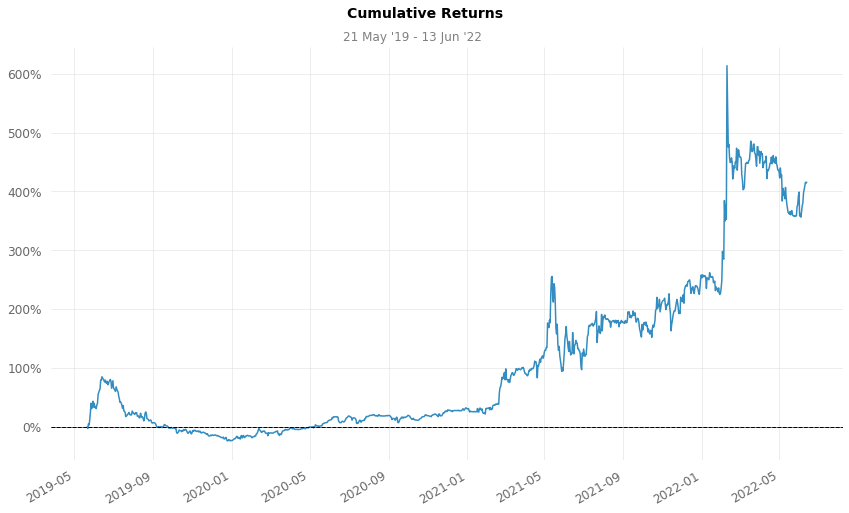

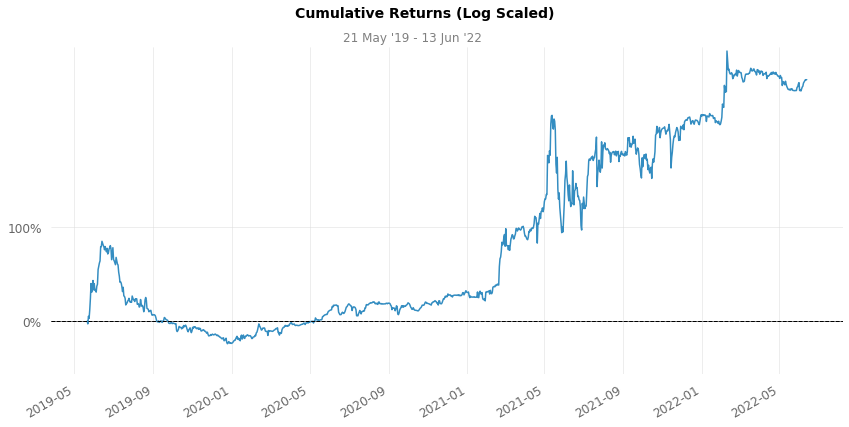

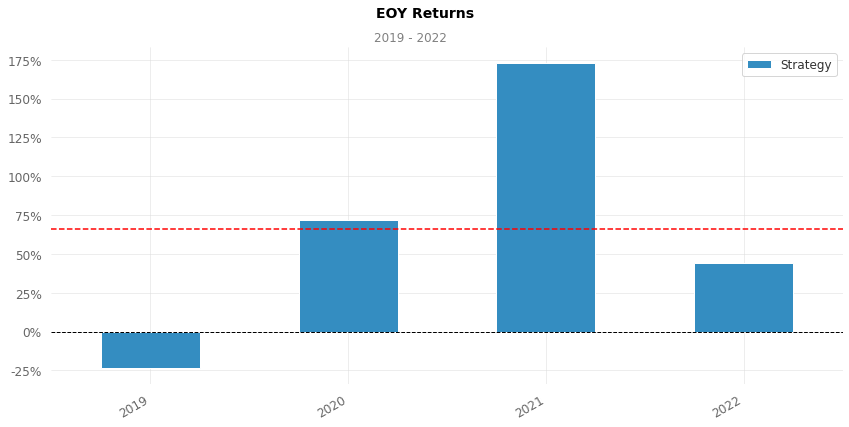

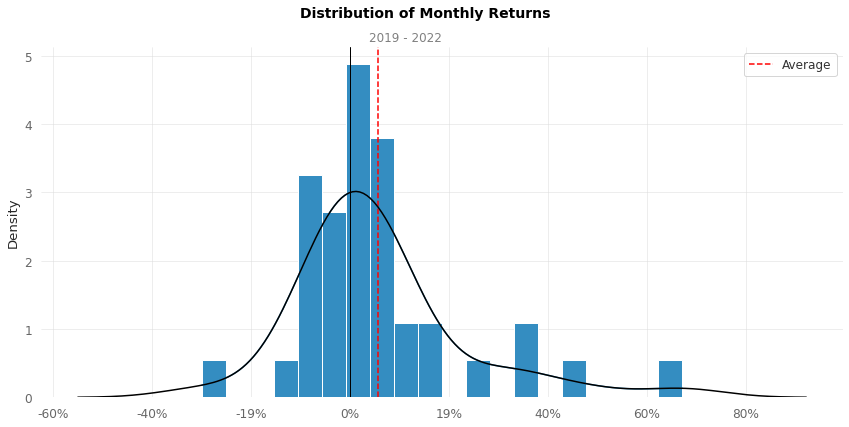

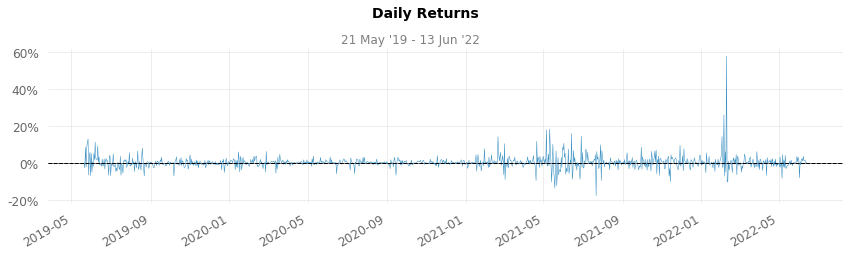

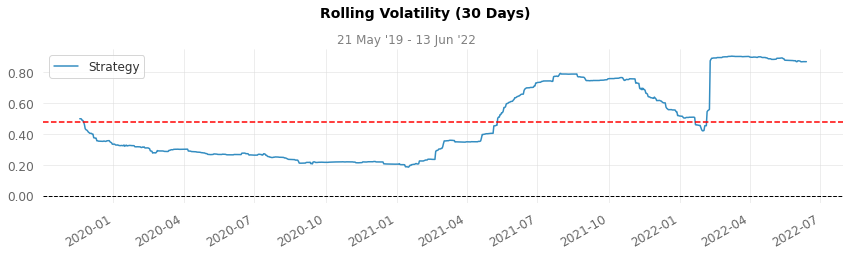

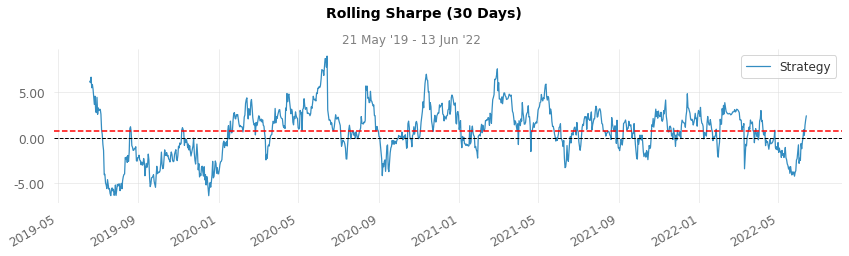

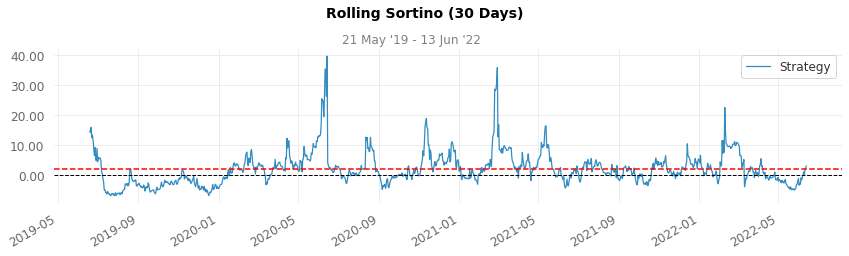

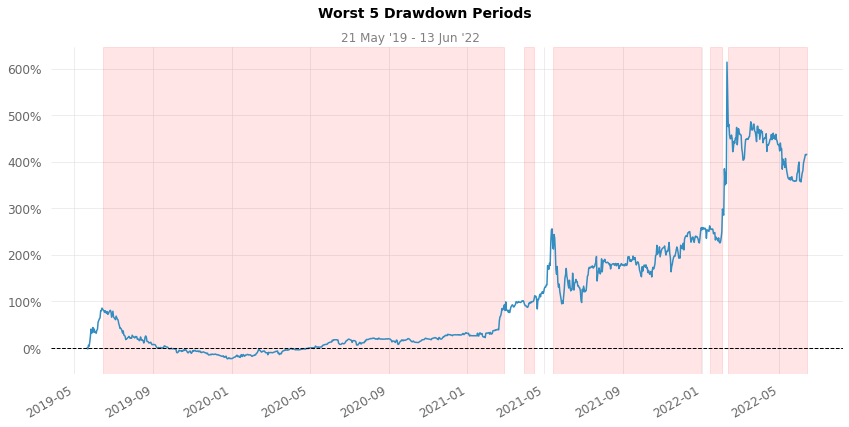

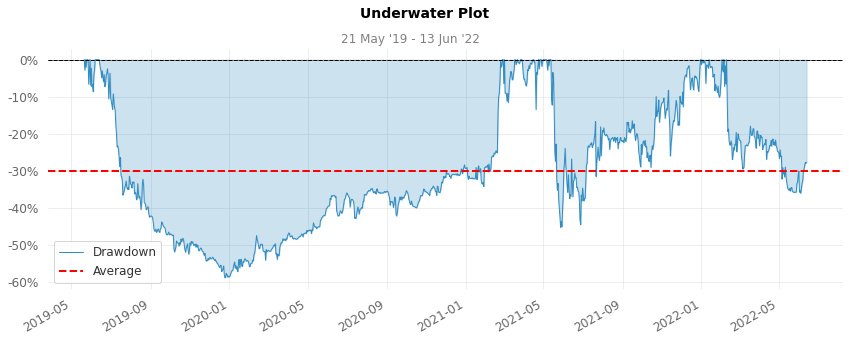

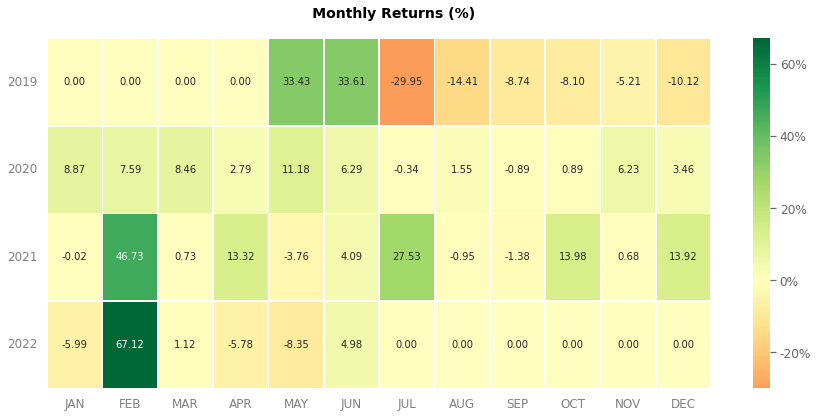

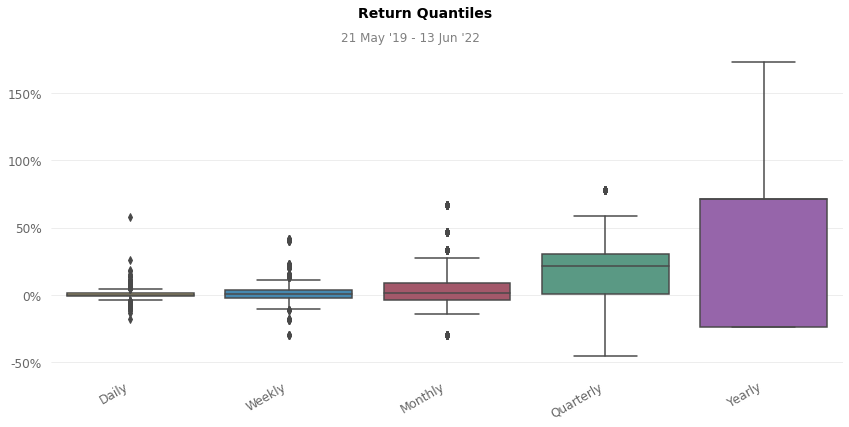

In [27]:
myreport(stock, figsize=(12, 9), periods_per_year=365, compounded=False, rolling_period = 30, match_dates=True)